In [1]:
# Libraries
library(readxl)
library(stringr)
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adjust PATH
wd <- getwd()
subdir <- "/bin"
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/vol/projects/odietric/covid19-bal-atlas-integration"

In [3]:
# Variables
in_url <- "https://syncandshare.desy.de/index.php/s/CrDgDwHRQNDWYcj"
in_url <- paste0(in_url, "/download")
in_file <- "docs/overview.xlsx"
plot_dir <- "analysis/BCB/overview/"
out_file <- "data/BCB/tidy-meta-data.csv"

# Colors
cols <- list(
    type = c(
        "Hospital" = "grey", 
        "ICU" = "gold", 
        "Ventilation" = "purple", 
        "ECMO" = "indianred",
        "Dexa" = "green"
    ),
    purification = c(
        "fresh" = "grey20",
        "frozen" = "grey80"
    )
)

# Shape
shape <- list()
shape$sex <- c(
  "Male" = "\u2642", 
  "Female" = "\u2640"
)
shape$endpoint <- c(
  deceased = "\u0445",
  discharged = "\u00BB",
  unknown = "\u003F"
)

In [4]:
# Download data
download.file(in_url, in_file)

In [5]:
# Read data
data <- list()
sheets <- excel_sheets(in_file)
for (i in sheets) {
    data[[i]] <- read_excel(path = in_file, sheet = i)
}
names(data)

New names:
• `` -> `...14`
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...9`
• `` -> `...10`
• `` -> `...12`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`
• `` -> `...26`
• `` -> `...28`
• `` -> `...29`
• `` -> `...30`
• `` -> `...31`
• `` -> `...32`
• `` -> `...33`
• `` -> `...35`
• `` -> `...36`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...41`
• `` -> `...42`
• `` -> `...43`
• `` -> `...44`
• `` -> `...45`
• `` -> `...46`
• `` -> `...47`
• `` -> `...48`
• `` -> `...49`
• `` -> `...50`
• `` -> `...51`
• `` -> `...53`
• `` -> `...55`
• `` -> `...56`
• `` -> `...57`
• `` -> `...58`
• `` -> `...59`
• `` -> `...60`
• `` -> `...61`
• `` -> `...62`
• `` -> `...63`


[1] "libraries"                    "patients"                    
[3] "samples"                      "examinations"                
[5] "hto_features"                 "hto_indices"                 
[7] "clinical_meta_data_variables" "Lung Mechanics"

In [6]:
# Clean patient data
patients <- data$patients

# Sex
index <- which(is.na(patients$sex))
patients$sex[index] <- "Unknown"
patients$sex <- str_trunc(patients$sex, 1, ellipsis = "")

# Age
lt <- data.frame(
    age = 1:120,
    group = rep(1:24, length.out = 120, each = 5)
    )
lt <- mutate(group_by(lt, group), min = min(age), max = max(age))
lt$group <- paste(lt$min, "_", lt$max)
patients$age <- lt$group[match(patients$age, lt$age)]
index <- which(is.na(patients$age))
patients$age[index] <- "Unknown"

# Other
patients$time <- difftime(patients$endpoint_date, patients$onset, units='days')
patients$onset_label <- as.Date(patients$onset, format="%h %Y")

In [7]:
# Calculate disease time
samples <- data$samples
index <- match(samples$patient, patients$id)
samples$time <- difftime(samples$date, patients$onset[index], units='days')
samples$time[is.na(samples$time)] <- -5

In [8]:
# Tidy libraries and samples
tidy <- data$libraries[, c("libname", "sample", "purification")]
index <- which(str_detect(tidy$sample, ":"))
for (i in index) {
    lib <- tidy$libname[i]
    x <- tidy$sample[i]
    y <- tidy$purification[i]
    x <- str_split(x, ",", simplify=TRUE)[1,]
    x <- str_split(x, ":", simplify=TRUE)[, 2]
    df <- data.frame(libname = lib, sample = x, purification = y)
    tidy <- rbind(tidy, df)
}
tidy <- tidy[-index, ]
samples$purification <- tidy$purification[match(samples$sample, tidy$sample)]

In [9]:
# Add columns to tidy

# Libraries
index <- match(tidy$libname, data$libraries$libname)
tidy <- cbind(tidy, data$libraries[index, c("Chemistry", "freeze_method", "sequenced")])

# Samples
index <- match(tidy$sample, samples$sample)
tidy <- cbind(tidy, samples[index, c("type", "patient", "dpso", "disease", "time",
                                     "disease_stage", "who_per_sample", "date")])

# Patients
index <- match(tidy$patient, patients$id)
tidy <- cbind(tidy, patients[index, c("cohort", "age", "sex", "outcome", "onset", "onset_label", "Dexa_group", "endpoint_date",
                                      "Dexa_category_str", "symptom_onset", "SCoV2_variant")])

In [10]:
# Clean examinations
examinations <- data$examinations
examinations <- gather(examinations, "type", "date", -timepoint, -id, -patient)
examinations$patient <- examinations$id
index <- match(examinations$id, patients$id)
examinations$onset <- patients$onset[index]
examinations$time <- examinations$date - examinations$onset
head(examinations,3)

patient,id,timepoint,type,date,onset,time
<chr>,<chr>,<chr>,<chr>,<dttm>,<dttm>,<drtn>
C19-CB-0913,C19-CB-0913,VOR_Einschluss,CT,2022-01-07,2021-12-14,24 days
C19-CB-0913,C19-CB-0913,t0_Einschluss,CT,NA,2021-12-14,NA days
C19-CB-0913,C19-CB-0913,t1,CT,2022-01-24,2021-12-14,41 days


In [11]:
# Add timelines
names(patients)
tl <- list()
tl[["Hospital"]] <- data.frame("from" = patients[["Hospital-admission"]],
                               "to"   = patients[["endpoint_date"]], 
                               "type" = "Hospital", patient = patients$id
                              )
tl[["ICU"]] <- data.frame("from" = patients[["ICU-admission"]],
                               "to"   = patients[["endpoint_date"]], 
                               "type" = "ICU", patient = patients$id
                              )
tl[["Ventilation"]] <- data.frame("from" = patients[["Ventilation-start"]],
                               "to"   = patients[["Ventilation-stop"]], 
                               "type" = "Ventilation", patient = patients$id
                              )
tl[["ECMO"]] <- data.frame("from" = patients[["ECMO-start"]],
                               "to"   = patients[["ECMO-stop"]], 
                               "type" = "ECMO", patient = patients$id
                              )
tl[["Dexa"]] <- data.frame("from" = patients[["Dexa-start"]],
                               "to"   = patients[["Dexa-stop"]], 
                               "type" = "Dexa", patient = patients$id
                              )
tl <- dplyr::bind_rows(tl)
unique(tl$type)
tl$type <- factor(tl$type, unique(tl$type))
tl <- gather(tl, "order", "time", -type, -patient)
tl$time <- difftime(tl$time, patients$onset, units='days')

[1] "name"                 "id"                   "cohort"              
 [4] "age"                  "sex"                  "outcome"             
 [7] "onset"                "Dexa Samples"         "Dexa_group"          
[10] "Dexa_category_num"    "Dexa_category_str"    "symptom_onset"       
[13] "Dexa-datediff_SO-BAL" "Dexa-start"           "Dexa-stop"           
[16] "ICU Mortality"        "death date"           "SCoV2_variant"       
[19] "date_PCR"             "Hospital-admission"   "ICU-admission"       
[22] "ICU"                  "Ventilation-start"    "Ventilation-stop"    
[25] "ECMO-start"           "ECMO-stop"            "endpoint_date"       
[28] "Outcome/Bemerkung"    "time"                 "onset_label"

[1] "Hospital"    "ICU"         "Ventilation" "ECMO"        "Dexa"

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 320 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_text()`).”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 320 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 

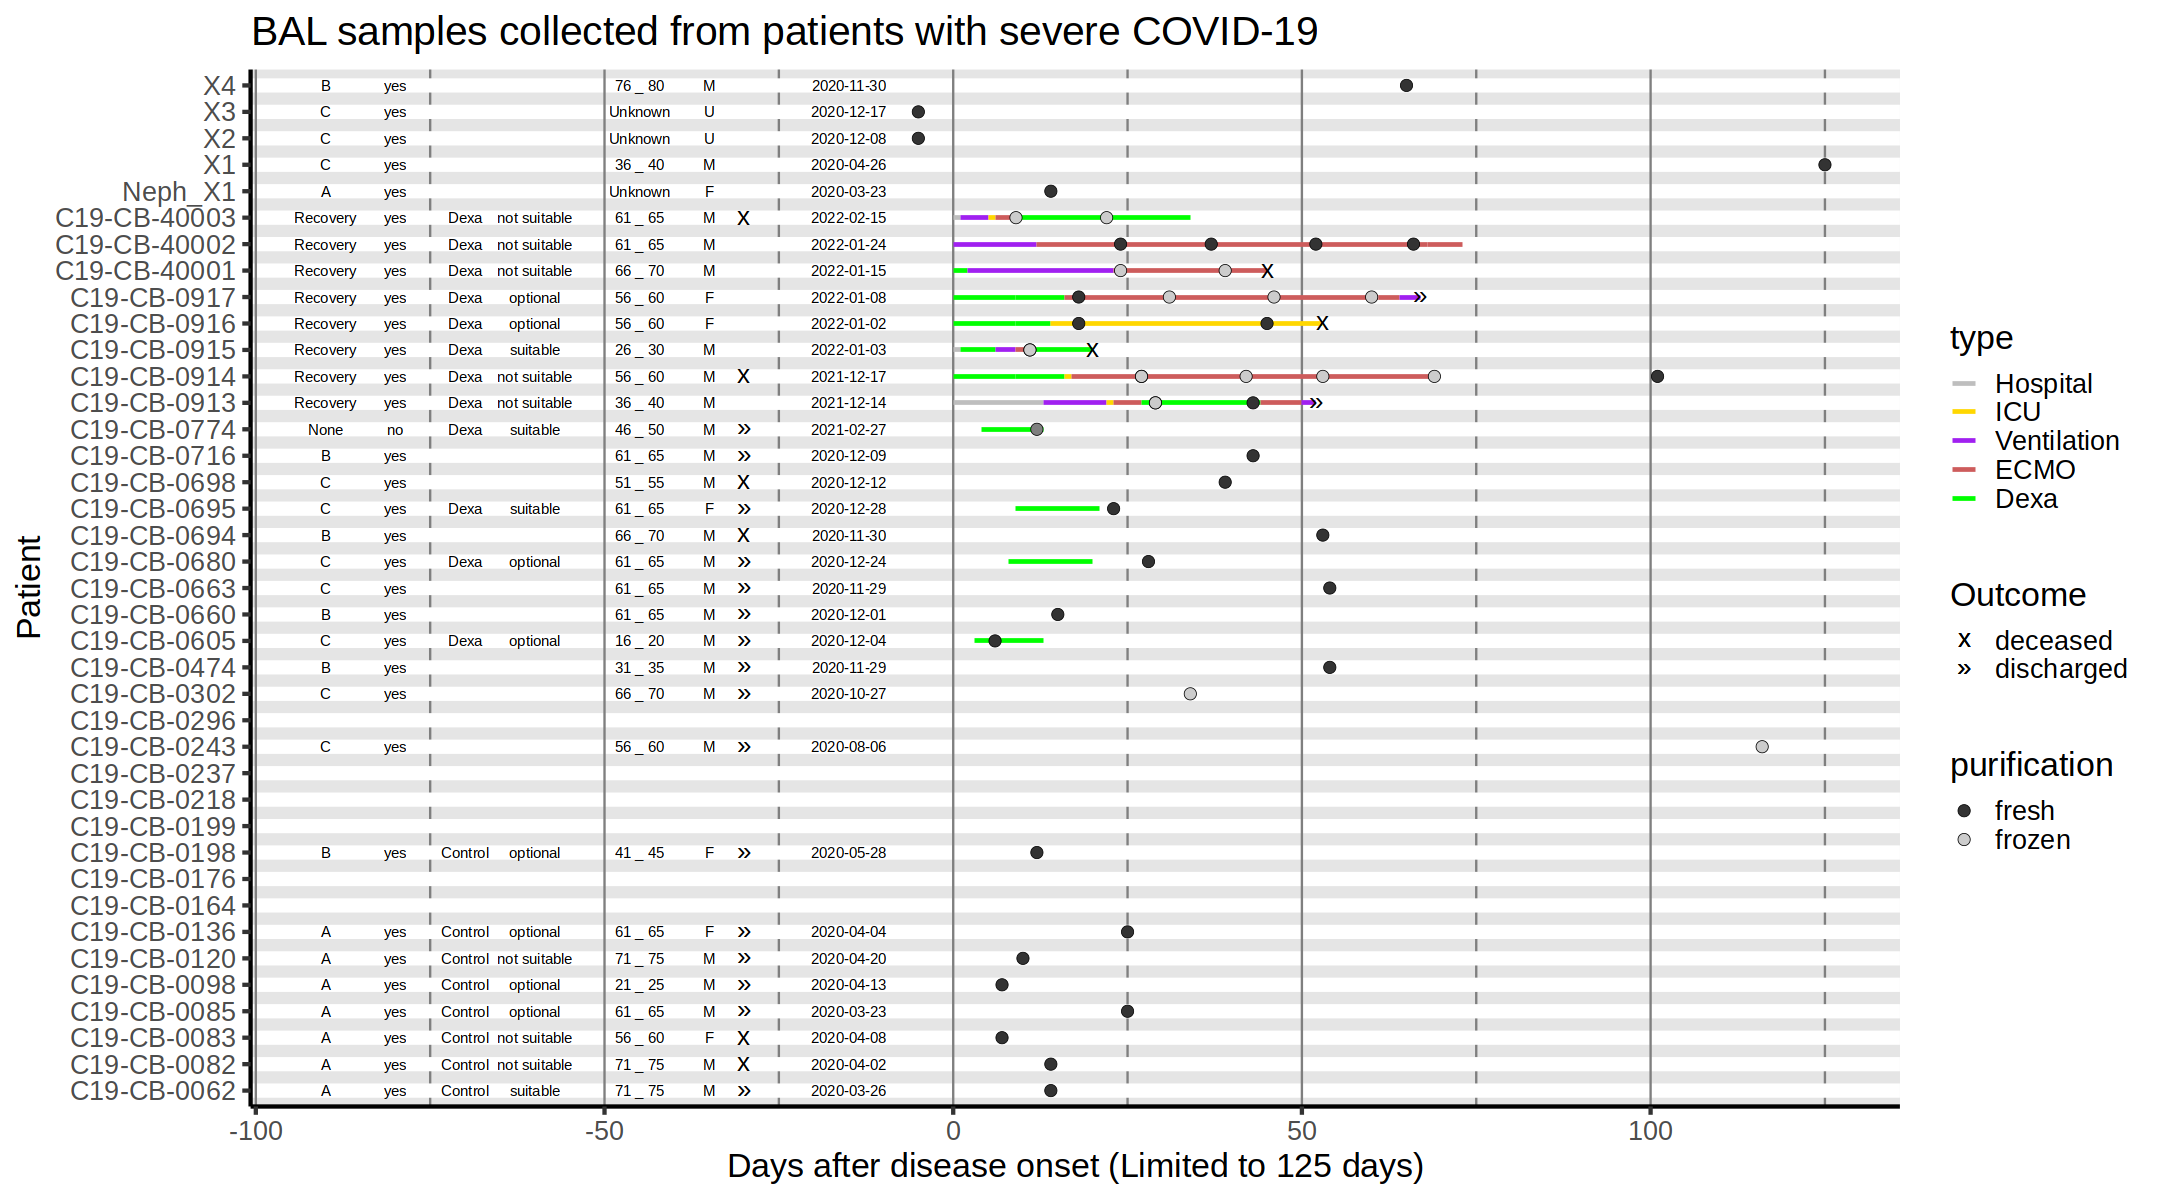

In [12]:
# Set time limit
time_max <- 125
index <- which(tidy$time > time_max)
tidy$time[index] <- time_max
tidy$patient <- factor(tidy$patient)

# Index
ind <- which(!duplicated(tidy$patient))
pt <- tidy[ind, ]

# Plot
options(repr.plot.width=18, repr.plot.height=10)
ggplot(tidy, aes(time, patient)) +
geom_point(size = 1, shape = 21, stroke = .1) +
geom_text(data = pt, aes(-15, patient, label = onset_label), size = 3, col = "black") + # Onset date
geom_text(data = pt, aes(-45, patient, label = age),  # Age
          size = 3, col = "black") +
geom_line(data = tl, aes(time, patient, col = type, group = patient), linewidth = 1) +
geom_text(data = pt, aes(-35, patient, label = sex), # Sex
           col = "black", size=3) + 
geom_point(data = pt[!is.na(tidy$endpoint_date), ], aes(endpoint_date - onset, patient, shape = outcome), # Outcome
           col = "black", size=5) +
geom_point(data = pt[is.na(tidy$endpoint_date),], aes(-30, patient, shape = outcome), # Outcome
           col = "black", size=5) +
geom_text(data = pt, aes(-70, patient, label = Dexa_group), # Dexa
           col = "black", size=3) +
geom_text(data = pt, aes(-60, patient, label = Dexa_category_str), # Dexa category
           col = "black", size=3) +
geom_text(data = pt, aes(-90, patient, label = cohort), # Cohort
           col = "black", size=3) +
geom_text(data = pt, aes(-80, patient, label = sequenced), # Sequenced
           col = "black", size=3) +
geom_point(aes(fill = purification), size = 3, shape = 21, stroke = .25) +
scale_shape_manual(values = shape$endpoint) +
scale_color_manual(values=cols$type) +
scale_fill_manual(values = cols$purification) +
labs(x = paste("Days after disease onset", "(Limited to", time_max, "days)"), y = "Patient",
    title = "BAL samples collected from patients with severe COVID-19") +
theme_classic(20) +
    theme(
      strip.text.y = ggplot2::element_text(angle = 0),
      panel.background = ggplot2::element_rect(fill = "grey90"),
      panel.grid.major.y = ggplot2::element_line(color = "white", size = 3),
      panel.grid.major.x = ggplot2::element_line(size = .5, color = "grey50"),
      panel.grid.minor.x = ggplot2::element_line(size = .5, color = "grey50")
    ) +
guides(shape = guide_legend(title = "Outcome"))
fn <- paste0(plot_dir, "sample-overview.png")
ggsave(fn, width=18, height=9, bg="white")

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 295 rows containing missing values (`geom_line()`).”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 295 rows containing missing values (`geom_line()`).”


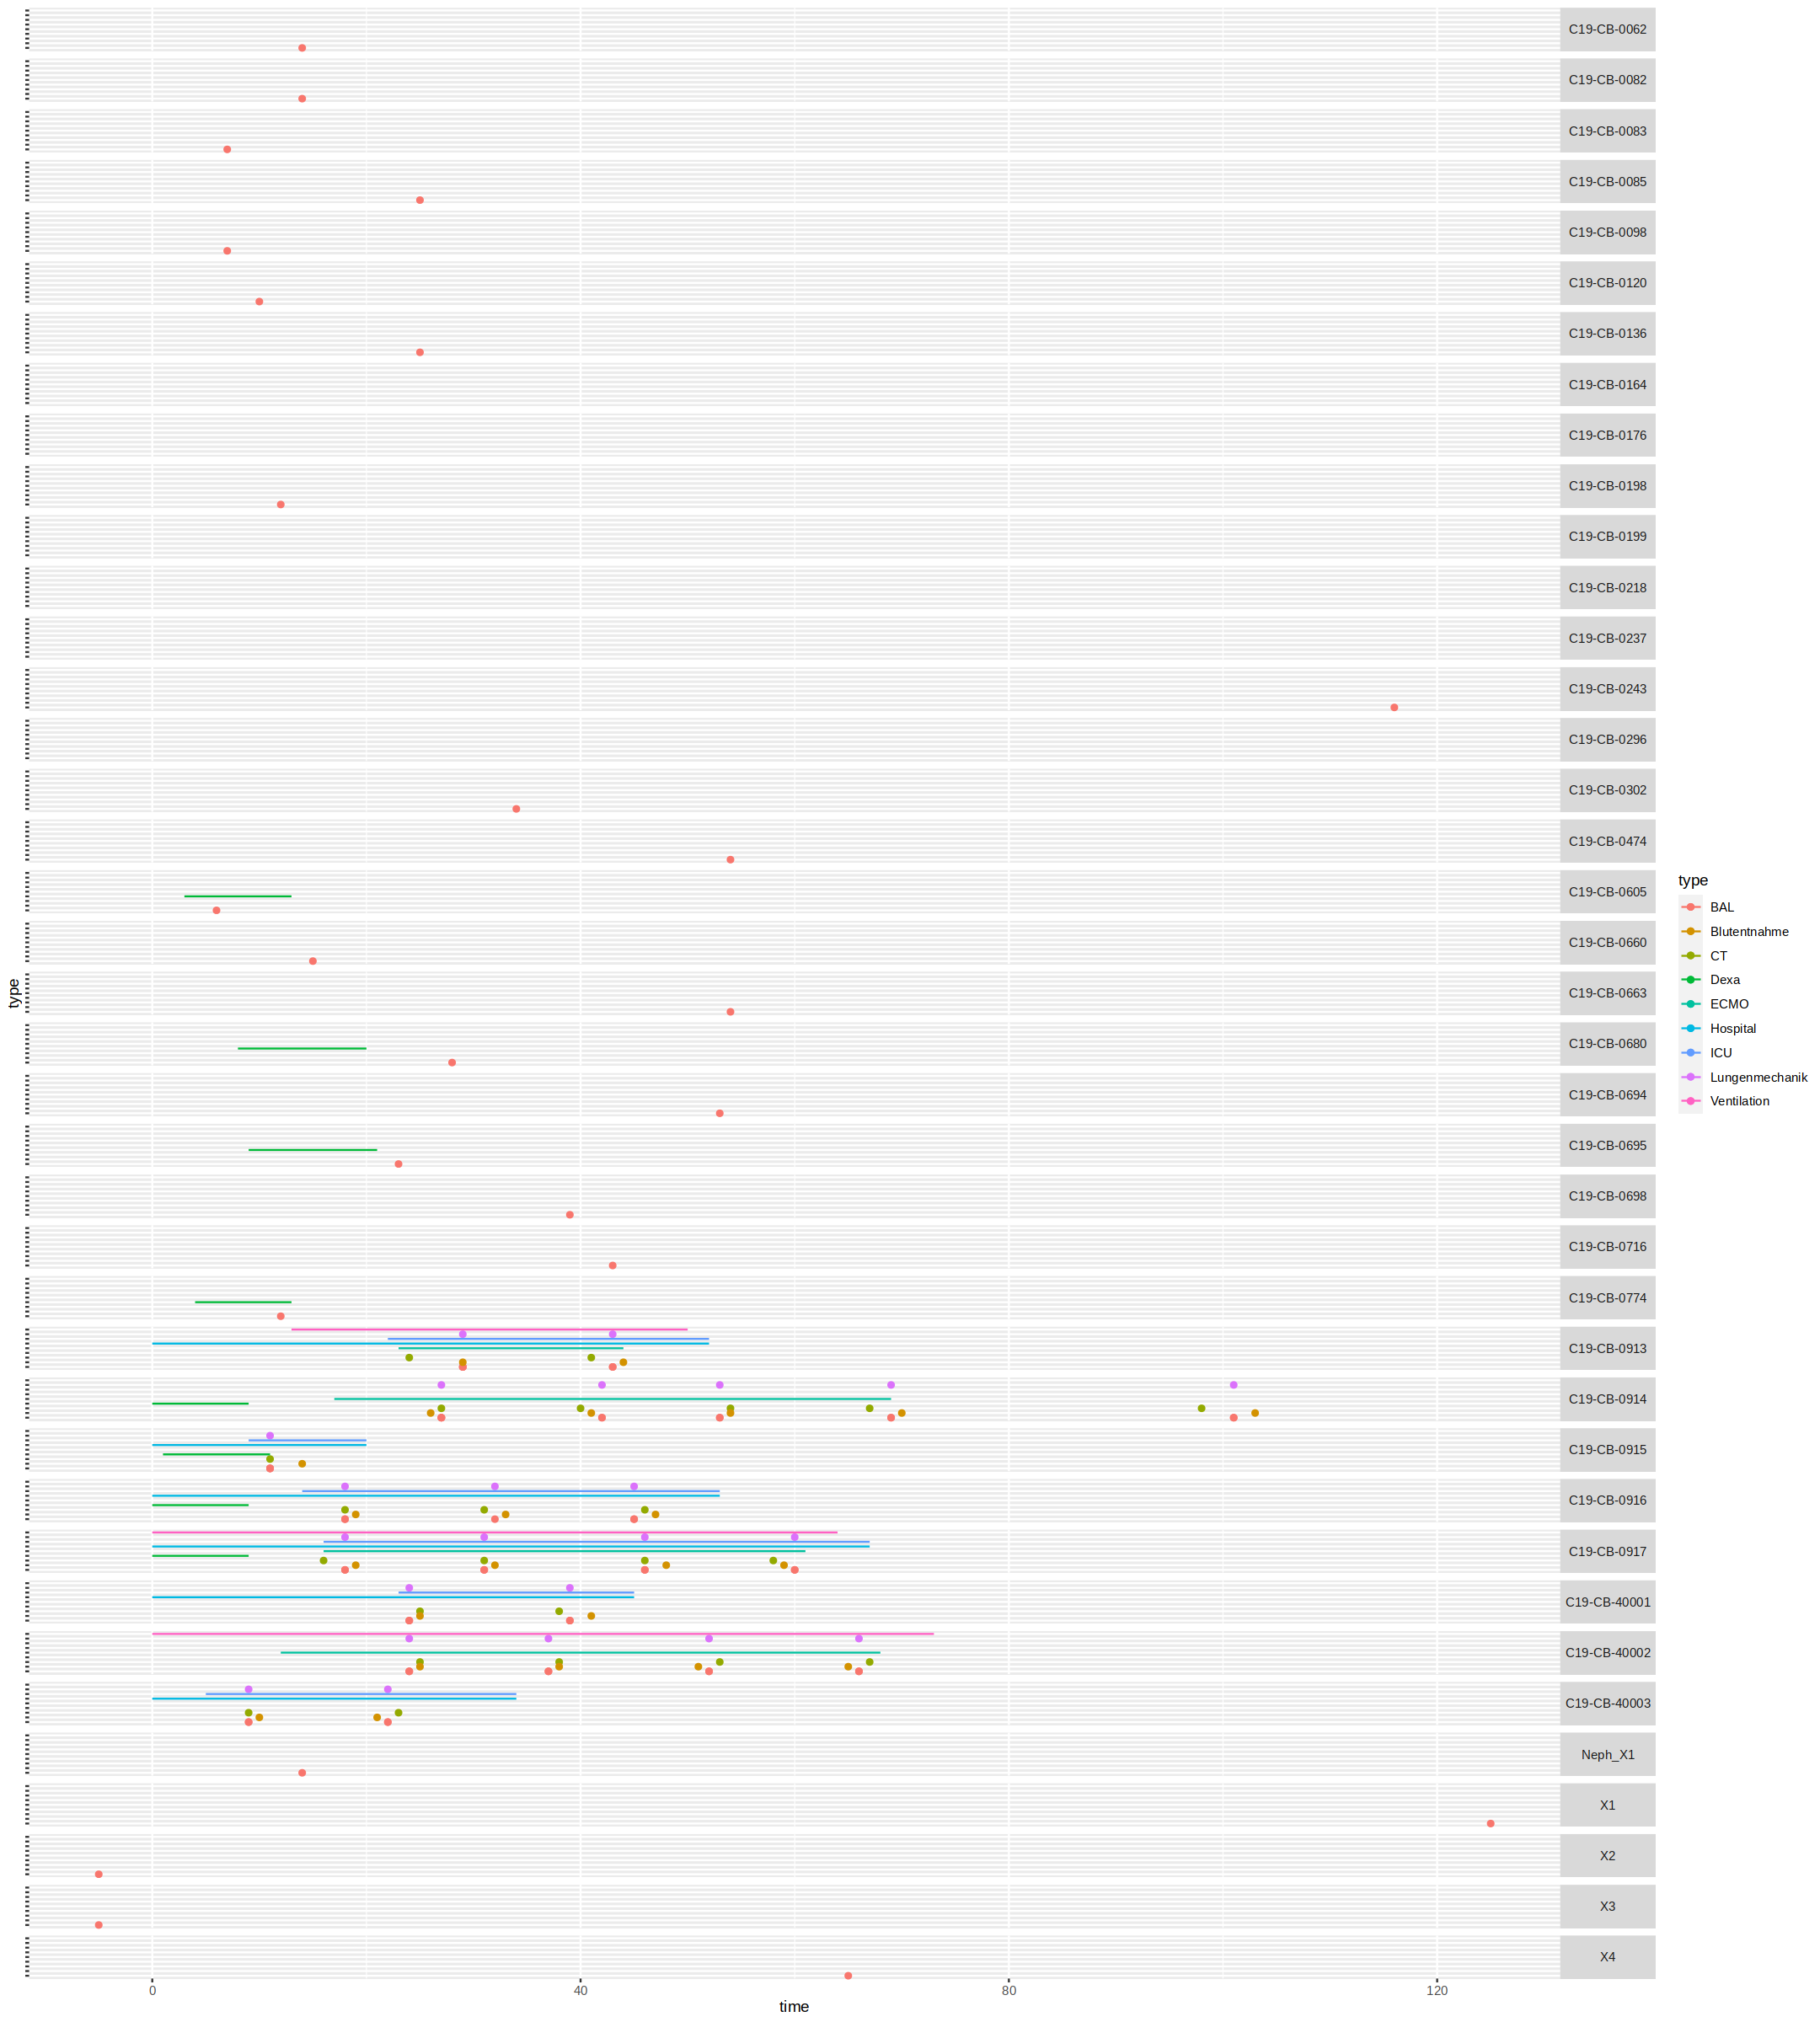

In [13]:
# Visualize patient-centric metadata overview

# Plot
options(repr.plot.width=18, repr.plot.height=20)
ggplot(tidy, aes(time, type, col=type)) +
  geom_point() +
  geom_point(data = examinations, aes(time, type)) +
  geom_line(data = tl, aes(time, type)) +
  facet_grid(patient~.) +
  theme(
      strip.text.y = element_text(angle=0),
      axis.text.y = element_blank()
  )
fn <- paste0(plot_dir, "patient-overview.png")
ggsave(fn, width=20, height=60, bg="white", limitsize = FALSE, dpi = 100)

[1] "No duplicated rows."


Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 78 rows containing missing values (`geom_line()`).”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 78 rows containing missing values (`geom_line()`).”


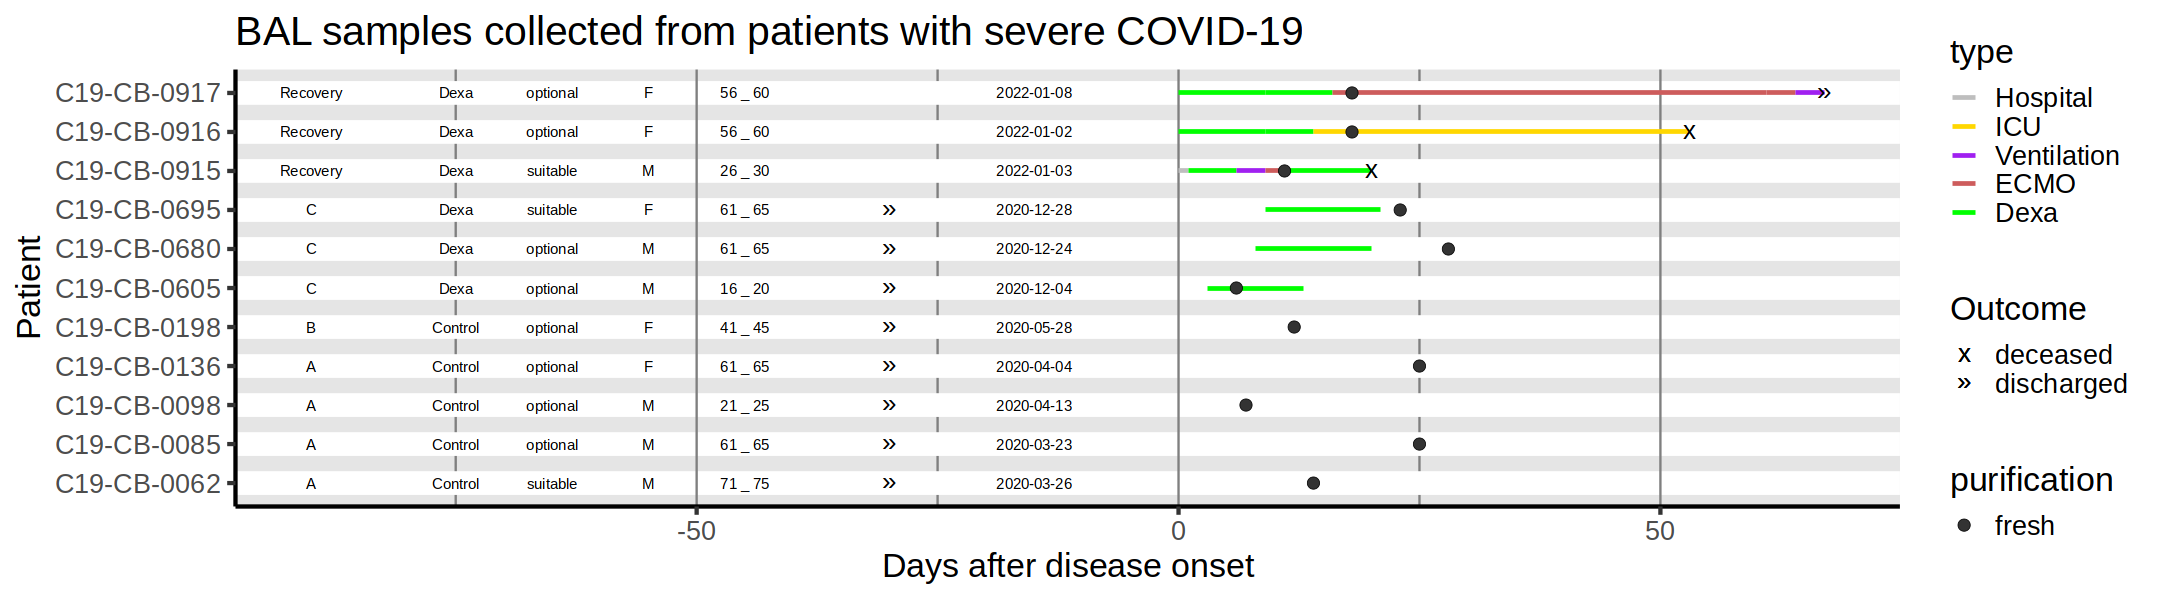

In [14]:
# Subset for Dexa analysis
tidy$dexa_selection <- tidy$Dexa_category_str %in% c("suitable", "optional") &
!tidy$time > 30 & tidy$purification != "frozen"
tidy$dexa_selection[is.na(tidy$dexa_selection)] <- FALSE
dexa <- tidy[tidy$dexa_selection, ]
dexa$patient <- factor(dexa$patient)
dtl <- tl[which(tl$patient %in% levels(dexa$patient)), ]

# Index
if (any(duplicated(dexa$patient))) {
    print("Duplicated rows present. Beware of overplotting.")
} else {
    print("No duplicated rows.")
}
ind <- which(!duplicated(dexa$patient))
pt <- dexa[ind, ]

# Plot
options(repr.plot.width=18, repr.plot.height=5)
ggplot(dexa, aes(time, patient)) +
geom_point(size = 1, shape = 21, stroke = .1) +
geom_text(data = pt, aes(-15, patient, label = onset_label), size = 3, col = "black") + # Onset date
geom_text(data = pt, aes(-45, patient, label = age),  # Age
          size = 3, col = "black") +
geom_line(data = dtl, aes(time, patient, col = type, group = patient), linewidth = 1) +
geom_text(data = pt, aes(-55, patient, label = sex), # Sex
           col = "black", size=3) + 
geom_point(data = pt[!is.na(pt$endpoint_date), ], aes(endpoint_date - onset, patient, shape = outcome), # Outcome
           col = "black", size=5) +
geom_point(data = pt[is.na(pt$endpoint_date),], aes(-30, patient, shape = outcome), # Outcome
           col = "black", size=5) +
geom_text(data = pt, aes(-75, patient, label = Dexa_group), # Dexa
           col = "black", size=3) +
geom_text(data = pt, aes(-65, patient, label = Dexa_category_str), # Dexa category
           col = "black", size=3) +
geom_text(data = pt, aes(-90, patient, label = cohort), # Cohort
           col = "black", size=3) +
geom_point(aes(fill = purification), size = 3, shape = 21, stroke = .25) +
scale_shape_manual(values = shape$endpoint) +
scale_color_manual(values=cols$type) +
scale_fill_manual(values = cols$purification) +
labs(x = paste("Days after disease onset"), y = "Patient",
    title = "BAL samples collected from patients with severe COVID-19") +
theme_classic(20) +
    theme(
      strip.text.y = ggplot2::element_text(angle = 0),
      panel.background = ggplot2::element_rect(fill = "grey90"),
      panel.grid.major.y = ggplot2::element_line(color = "white", size = 5),
      panel.grid.major.x = ggplot2::element_line(size = .5, color = "grey50"),
      panel.grid.minor.x = ggplot2::element_line(size = .5, color = "grey50")
    ) +
guides(shape = guide_legend(title = "Outcome"))
fn <- paste0(plot_dir, "sample-overview-dexa.png")
ggsave(fn, width=18, height=5, bg="white")

In [15]:
# Save metadata
head(tidy, 3)
names(tidy)
print(paste("Writing data to", out_file))
write.csv(tidy, out_file)

,libname,sample,purification,Chemistry,freeze_method,sequenced,type,patient,dpso,disease,⋯,sex,outcome,onset,onset_label,Dexa_group,endpoint_date,Dexa_category_str,symptom_onset,SCoV2_variant,dexa_selection
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<dttm>,<date>,<chr>,<dttm>,<chr>,<chr>,<chr>,<lgl>
1,L01,BAL_1,fresh,SC3Pv3_1,NA,yes,BAL,Neph_X1,14,COVID-19,⋯,F,NA,2020-03-23,2020-03-23,NA,NA,NA,NA,NA,FALSE
2,L02,BAL_2,fresh,SC3Pv3_1,NA,yes,BAL,C19-CB-0062,14,COVID-19,⋯,M,discharged,2020-03-26,2020-03-26,Control,NA,suitable,43916,NA,TRUE
3,L03,BAL_3,fresh,SC3Pv3_1,NA,yes,BAL,C19-CB-0083,7,COVID-19,⋯,F,deceased,2020-04-08,2020-04-08,Control,NA,not suitable,43929,NA,FALSE


[1] "libname"           "sample"            "purification"     
 [4] "Chemistry"         "freeze_method"     "sequenced"        
 [7] "type"              "patient"           "dpso"             
[10] "disease"           "time"              "disease_stage"    
[13] "who_per_sample"    "date"              "cohort"           
[16] "age"               "sex"               "outcome"          
[19] "onset"             "onset_label"       "Dexa_group"       
[22] "endpoint_date"     "Dexa_category_str" "symptom_onset"    
[25] "SCoV2_variant"     "dexa_selection"

[1] "Writing data to data/BCB/tidy-meta-data.csv"
